In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
climate_engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
ClimateBase = automap_base()
# reflect the tables
ClimateBase.prepare(autoload_with= climate_engine)

In [6]:
# View all of the classes that automap found
ClimateBase.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
ClimateMeasurement = ClimateBase.classes.measurement
ClimateStation = ClimateBase.classes.station

In [8]:
# Create our session (link) from Python to the DB
climate_session = Session(climate_engine)


# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
latest_climate_date = climate_session.query(ClimateMeasurement.date).order_by(ClimateMeasurement.date.desc()).first()
latest_climate_date


('2017-08-23',)

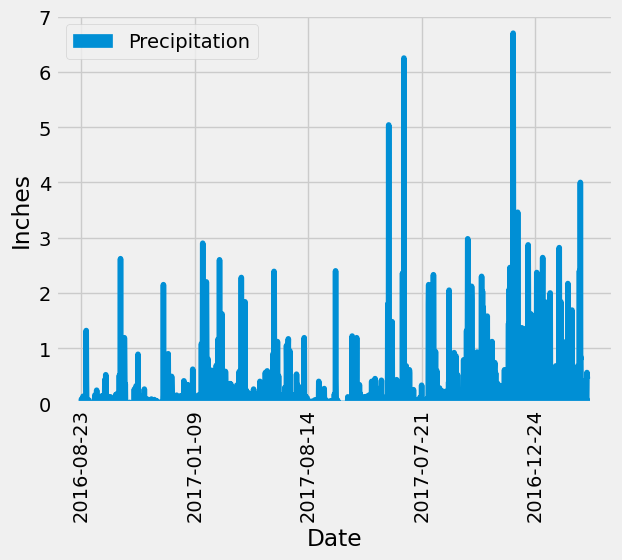

In [17]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
year_ago_from_latest = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Perform a query to retrieve the date and precipitation scores
last_year_precipitation = climate_session.query(ClimateMeasurement.date, ClimateMeasurement.prcp).\
    filter(ClimateMeasurement.date >= year_ago_from_latest)

# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_data_df = pd.DataFrame(last_year_precipitation, columns = [ "Date", "Precipitation"])
precipitation_data_df.head()

# Sort the DataFrame by date
precipitation_data_df.sort_values('Date')

# Use Pandas Plotting with Matplotlib to plot the data
precipitation_data_df.plot(kind = "area", x = "Date", y = "Precipitation", rot = 90)
plt.xlabel("Date")
plt.ylabel("Inches")
plt.show()

In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_stats = precipitation_data_df['Precipitation'].describe()
precipitation_stats

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: Precipitation, dtype: float64

# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number of stations in the dataset
total_climate_stations = climate_session.query(func.count(ClimateStation.station)).scalar()
total_climate_stations

9

In [13]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active_stations = climate_session.query(ClimateMeasurement.station, func.count(ClimateMeasurement.station).label('count')).\
    group_by(ClimateMeasurement.station).\
    order_by(func.count(ClimateMeasurement.station).desc()).all()
most_active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
# Identify the most active station ID
active_station_id = most_active_stations[0][0]
station_temperature_stats = climate_session.query(func.min(ClimateMeasurement.tobs), func.max(ClimateMeasurement.tobs), func.avg(ClimateMeasurement.tobs)).\
    filter(ClimateMeasurement.station == active_station_id).first()
station_temperature_stats

(54.0, 85.0, 71.66378066378067)

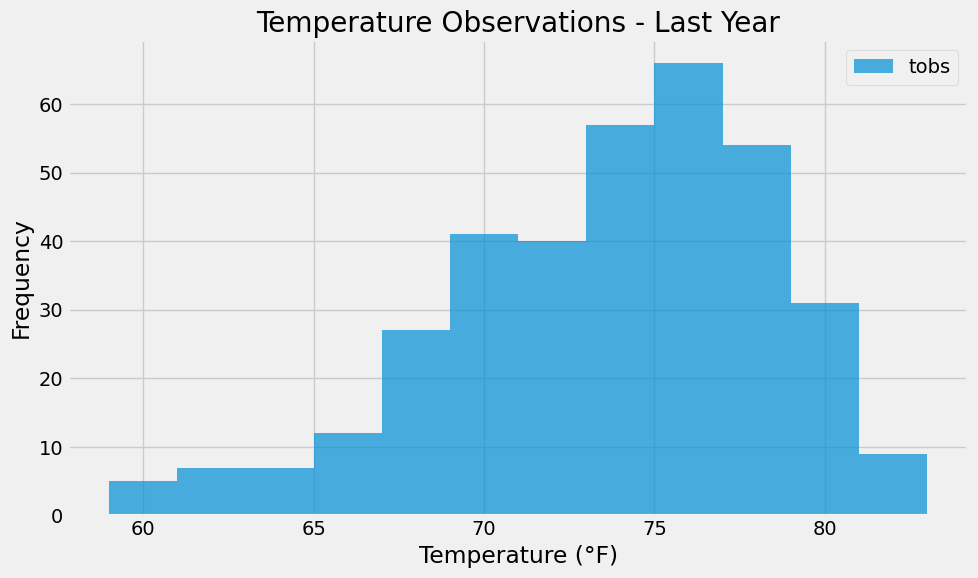

In [15]:
# Query the last 12 months of temperature observation data for the most active station
most_recent_date_active = climate_session.query(func.max(ClimateMeasurement.date)).\
    filter(ClimateMeasurement.station == active_station_id).scalar()
year_ago_active = dt.datetime.strptime(most_recent_date_active, '%Y-%m-%d') - dt.timedelta(days=365)
temperature_data_active = climate_session.query(ClimateMeasurement.tobs).\
    filter(ClimateMeasurement.station == active_station_id,
           ClimateMeasurement.date >= year_ago_active).all()

# Plot the results as a histogram
active_station_temps_df = pd.DataFrame(temperature_data_active, columns=['Temperature'])
plt.figure(figsize=(10, 6))
plt.hist(active_station_temps_df['Temperature'], bins=12, alpha=0.7, label='tobs')
plt.title('Temperature Observations - Last Year')
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()

# Close Session

In [16]:
# Close Session
climate_session.close()